# Vitber project - industrial mathematics
#### _Dimensionality reduction and noise removal of face images with Non-Negative Matrix Factorization_

In this project we are want to be able to reduce the amount of data needed to describe a system. This will be done by using Non-Negative Matrix Factorization (NMF), which means that a non-negative matrix A can be writtes as $$  A \approx A_{NMF} = WH$$, where $W$ and $H$ are two rectangular matrix. The purpose here is that the dimentions of the sum of $W$ and $H$ is smaller than for $A$. Notice that we accept an approximation of $A$ when multiplying $WH$. 

_Introduksjonen trenger mer introdusksjon;)_

Task 1 

a) If we assume that A has all non-negative elements, and that the factorization matrices W and H are positive. We can easily show that $W_k$ and $H_k$ are non-negative. The two iterates are defined by:

$ H_{k+1} = H_k \odot (W_k^T A) \oslash (W_k^T W_k H_k)$

$W_{k+1} = W_k \odot (A H_{k+1}^T) \oslash (W_k H_{k+1} H_{k+1}^T)$

From this we can see that by the operations being used it is impossible to obtain any negative elements in the following iterates. (Kan vise dette med komponentvis regning, evt finne et bedre argument)

b)

We obtain our $W$ and $H$ matrices by finding the following minimum:

$\underset{W,H}{min} \: || A-WH ||_F$

Further, we know, from the introduction document, that the updated iterates $H_{k+1}$ and $W_{k+1}$ are weakly monotonically non-increasing, by satifying:
$||A - W_{k+1} H_{k+1}||  \leq || A - W_k H_k ||_F$, thus the action of element-wise multiplication with: $(W_k^T A) \oslash (W_k^T W_k H_k)$ and $(A H_{k+1}^T) \oslash (W_k H_{k+1} H_{k+1}^T)$ acts as a contraction for $W_k$ and $H_k$. These contraction mapping assure that we eventually will reach a point in our iteration where we have arrived at the unique fixed point corresponding to the contraction mapping. Thus for the case where $H_k$ is this fixed point, we know that $H_{k+1}$ is equal to $H_k$, and thus the operation $(W_k^T A) \oslash (W_k^T W_k H_k)$ is equal to a matrix of ones, denoted $\textbf{11}$. 
By substituting the expression $(W_k^T A) \oslash (W_k^T W_k H_k)$ with a matrix of ones we get:

$H_{k+1} = H_k \odot \textbf{11}$ - clearly showing $H_k$ is a fixed point.

With this in mind, we consider the case where $WH = A$. In our definition for obtaining $W$ and $H$ we see that in this case the value of: $\underset{W,H}{min} \: || A-WH ||_F$ is zero. And we know the F-norm to be non-negative, thus this is the true minimum, and $W$ and $H$ must be fixed points. 

c)

By initializing $H_0$ and $W_0$ as two matrices of only zeros, we quickly see that the iterations given by: $H_{k+1} = H_k \odot (W_k^T A) \oslash (W_k^T W_k H_k)$ and  $W_{k+1} = W_k \odot (A H_{k+1}^T) \oslash (W_k H_{k+1} H_{k+1}^T)$ yields nothing but further zero-matrices. So how does this hold up, considering that the Banach fixed point theorem states that the fixed point corresponding to the operations as mentioned in b yields a unique point? Does not the result above imply that the two zero-initialization also qualify as fixed points? Well perhaps, but this does not supply us with any solution to the factorization, as if  $W$ and $H$ are zero-matrices the expression $|| A-WH ||_F$ is actually equal to $||A||_F$, so not very close to zero. So the difficulty with having this as the initialization is that we get nowhere.

In [1]:
!apt update
!apt install ffmpeg libsm6 libxext6 -y
!pip install opencv-python
!pip install --upgrade pip


The operation couldn’t be completed. Unable to locate a Java Runtime that supports apt.
Please visit http://www.java.com for information on installing Java.

The operation couldn’t be completed. Unable to locate a Java Runtime that supports apt.
Please visit http://www.java.com for information on installing Java.

     |████████████████████████████████| 46.3 MB 9.9 kB/s eta 0:00:01    |██████▎                         | 9.0 MB 2.6 MB/s eta 0:00:15     |███████████████▋                | 22.5 MB 4.0 MB/s eta 0:00:06     |██████████████████▊             | 27.0 MB 4.7 MB/s eta 0:00:05     |██████████████████████████████▊ | 44.4 MB 365 kB/s eta 0:00:06
     |████████████████████████████████| 2.1 MB 1.7 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.4
    Uninstalling pip-20.2.4:
      Successfully uninstalled pip-20.2.4


In [8]:

import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
#import cv2
import os
import time
#from tabulate import tabulate
from numba import jit
import scipy

In [11]:
#Defining the four matrces given in the assignment:
A1 = np.array([[1,0],[0,1]])
A2 = np.array([[1,2],[1,1], [1,2]])
A3 = np.array([[2,1,1],[2,1,1], [1,1,2]])
A4 = np.array([[2,1,0],[1,2,3], [0,3,3]])
np.random.seed(0)

#Setting max iterations: 
max_it = 1000


#1d) Implementing the NMF algorithm 1 described on page 10 in the assignment: 
def NMF(A, d, delta, tol):
    """
    Input: 
        A: mxn matrix
        d: number of components
        delta: safe division constant
        tol: tolerance
    Output:
        Returns W and H such that WH = A_nmf (approximate NMF factorization)
    """

    W_rows = np.size(A,0)
    H_cols = np.size(A,1)

    W_cols = d
    H_rows = d


    #Creating random matrix H0 and H0 and scaling them
    H0 = np.random.uniform(0, 1, size=(H_rows,H_cols)) * np.sqrt(np.mean(A)/d)
    W0 = np.random.uniform(0, 1, size=(W_rows,W_cols)) * np.sqrt(np.mean(A)/d)

    Hk = H0
    Wk = W0
    H = Hk
    norm_arr = np.zeros(max_it)
    for k in range(max_it):        
        H = np.divide(np.multiply(Hk, np.dot(Wk.transpose(), A)) ,np.dot(np.dot(Wk.transpose(),Wk),Hk)+delta)
        W = np.divide(np.multiply(Wk, np.dot(A, H.transpose())) ,np.dot(np.dot(Wk,H),H.transpose()) + delta)
        Hk = H
        Wk = W
        norm_arr[k] = np.linalg.norm(A-np.dot(W,H), 'fro')
    
    A_nmf = np.dot(W,H)

    return Wk, H, A_nmf, norm_arr


div_const = 10**(-9)
d = 1 
tol = 0.1


np.random.seed(0)
W1, H1, A_nmf1, fro_norm1 = NMF(A1, d, div_const, tol)
W3, H3, A_nmf3, fro_norm3 = NMF(A2, d, div_const, tol)

np.random.seed(5)
W2, H2, A_nmf2, fro_norm2 = NMF(A1, d, div_const, 0.1)
W4, H4, A_nmf4 , fro_norm4= NMF(A2, d, div_const, 0.1)

table = [[ "d",'Start matrix',"", 'W', 'H', "WH", "||A-WH||_F"], 
        [d,"A1:",A1, W1, H1, np.dot(W1,H1), np.linalg.norm(A1-np.dot(W1,H1), 'fro')], 
        [d,"A1:",A1, W2, H2, np.dot(W2,H2), np.linalg.norm(A1-np.dot(W2,H2), 'fro')],
        [d,"A2:",A2, W3, H3, np.dot(W3,H3), np.linalg.norm(A2-np.dot(W3,H3), 'fro')], 
        [d,"A2:",A2, W4, H4, np.dot(W4,H4), np.linalg.norm(A2-np.dot(W4,H4), 'fro')]
        ]
    
#print(tabulate(table))



In [12]:
@jit(nopython=True, fastmath=True)
def NMF2(A, d, div_const, tol, max_it = 1000):
    """
    Input: 
        A: mxn matrix
        d: number of components
        div_const: safe division constant
        tol: tolerance
    Output:
        Returns W and H such that WH = A_nmf (approximate NMF factorization)
    """

    W_rows = A.shape[0]
    H_cols = A.shape[1]

    W_cols = d
    H_rows = d

    delta = 10e-7
    
    #Creating random matrix H0 and H0 and scaling them
    H0 = (np.random.uniform(0.0, 1.0, size=(H_rows,H_cols)) * np.sqrt(np.mean(A)/d)).astype(np.float32)
    W0 = (np.random.uniform(0.0, 1.0, size=(W_rows,W_cols)) * np.sqrt(np.mean(A)/d)).astype(np.float32)

    Hk = H0
    Wk = W0
    H = Hk
    norm_arr = np.zeros(max_it)

    for k in range(max_it):        
        H = (np.divide(np.multiply(Hk, np.dot(Wk.transpose(), A.astype(np.float32))) ,np.dot(np.dot(Wk.transpose(),Wk),Hk)+div_const)).astype(np.float32)
        W = (np.divide((np.multiply(Wk, np.dot(A.astype(np.float32), H.transpose()))), (np.dot(np.dot(Wk,H),H.transpose()) + div_const))).astype(np.float32)
        Hk = H
        Wk = W
        norm_arr[k] = np.linalg.norm(A-np.dot(W,H), 'fro')
    
    A_nmf = np.dot(W,H)

    return W, H, A_nmf, norm_arr


div_const = 10**(-9)
d = 1 
tol = 0.1

NMF2(A1, d, div_const, tol)

ValueError: Invalid norm order for matrices.

In the table above the matrices involved in the Non-Negative Matrix Factorization of $A_1$ and  $A_2$ printed. It is noticable that there is a difference in $A$ and $WH$. Still we see that the Frobenius norm of the difference is under 1. We also notice that the difference is smaller for A2, which is a larger matrix. It is also noticable that this length is independent of the startvalues of $W$ and $H$, since the product $WH$ is the same for both solutions. 

In [13]:
#1e) 
div_const = 10**(-9)
d = 2
tol = 0.1


np.random.seed(0)
W1, H1, A_nmf1, fro_norm1 = NMF(A1, d, div_const, tol)
W3, H3, A_nmf3, fro_norm3 = NMF(A2, d, div_const, tol)

np.random.seed(5)
W2, H2, A_nmf2, fro_norm2 = NMF(A1, d, div_const, 0.1)
W4, H4, A_nmf4 , fro_norm4= NMF(A2, d, div_const, 0.1)

table = [[ "d",'Start matrix', 'W', 'H', "WH", "||A-WH||_F"], 
        [d, A1, W1, H1, np.dot(W1,H1), np.linalg.norm(A1-np.dot(W1,H1), 'fro')], 
        [d, A1, W2, H2, np.dot(W2,H2), np.linalg.norm(A1-np.dot(W2,H2), 'fro')],
        [d, A2, W3, H3, np.dot(W3,H3), np.linalg.norm(A2-np.dot(W3,H3), 'fro')], 
        [d, A2, W4, H4, np.dot(W4,H4), np.linalg.norm(A2-np.dot(W4,H4), 'fro')]
        ]
    
#print(tabulate(table))

Here we can see that $||A_1 - WH||_F$ is very close to zero with a value of approximately $8.63\cdot10^{-10}$. $WH$ is apparantly equivalent to the start matrix for both $A_1$ and $A_2$. The results are therefore very reasonable. 

In [14]:
#1f

def getRank(M):
    i=0
    eigs = la.svd(M)[1] #Finding singular values instead of eigenvalues enables this computation for non-square matrices.
    for el in eigs:
        if(el != 0):
            i += 1
    return i

print('The ranks of A3 and A4 is', getRank(A3), 'and', getRank(A4))

The ranks of A3 and A4 is 3 and 3


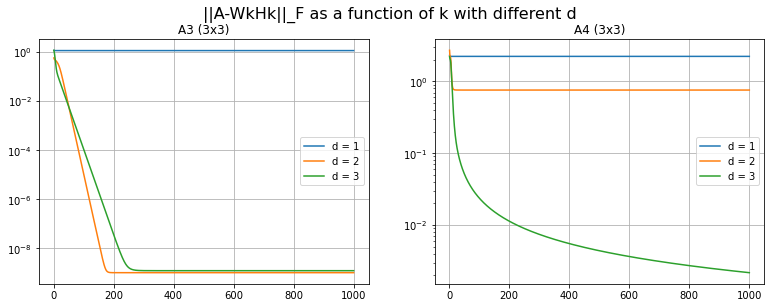

In [15]:
#1g
np.random.seed(0)

d = 1
W1, H1, A_nmf1, fro_norm1 = NMF(A3, d, div_const, tol)
W2, H2, A_nmf2, fro_norm2 = NMF(A4, d, div_const, tol)
d = 2
W1, H3, A_nmf3, fro_norm3 = NMF(A3, d, div_const, tol)
W4, H4, A_nmf4, fro_norm4 = NMF(A4, d, div_const, tol)
d = 3
W5, H5, A_nmf5, fro_norm5 = NMF(A3, d, div_const, tol)
W6, H6, A_nmf6, fro_norm6 = NMF(A4, d, div_const, tol)

x = list(range(1, max_it+1))


fig, ax = plt.subplots(1, 2)
fig.set_figheight(4.5)
fig.set_figwidth(13)
fig.suptitle("||A-WkHk||_F as a function of k with different d", size = 16)
ax[0].set_title("A3 (3x3)")
ax[0].semilogy(x, fro_norm1, label = "d = 1")
ax[0].semilogy(x, fro_norm3, label = "d = 2")
ax[0].semilogy(x, fro_norm5, label = "d = 3")
ax[0].legend(loc = 'center right')
ax[0].grid()

ax[1].set_title("A4 (3x3)")
ax[1].semilogy(x, fro_norm2, label = "d = 1")
ax[1].semilogy(x, fro_norm4, label = "d = 2")
ax[1].semilogy(x, fro_norm6, label = "d = 3")
ax[1].legend(loc = 'center right')
ax[1].grid()



The size of d is such that a larger d converges closer to zero. When looking at the plots one can see that $||A-W_kH_k||_F$ decreases as $k$ increases. We can therefor assume that equation (17) on page 9 is satisfied. This can  be checked using a simple _for_ and _if_ loop:

In [16]:
for i in range(len(fro_norm1)-1):
    if (fro_norm1[i+2] > fro_norm1[i+1]):
        diff = fro_norm1[i+2] - fro_norm1[i+1]
        print ("A3 (d=1):", ": Not satisfied at", i, ", with differance", diff)
        break
for i in range(len(fro_norm3)-1):
    if (fro_norm3[i+2] > fro_norm3[i+1]):
        diff = fro_norm3[i+2] - fro_norm3[i+1]
        print ("A3 (d=2):",  ": Not satisfied at", i,", with differance", diff)
        break
for i in range(len(fro_norm5)-1):
    if (fro_norm5[i+2] > fro_norm5[i+1]):
        diff = fro_norm5[i+2] - fro_norm5[i+1]
        print ("A3 (d=3):", ": Not satisfied at", i,", with differance", diff)
        break
for i in range(len(fro_norm2)-2):
    if (fro_norm2[i+2] > fro_norm2[i+1]):
        diff = fro_norm2[i+2] - fro_norm2[i+1]
        print ("A4 (d=1):", ": Not satisfied at", i,", with differance", diff)
        break
for i in range(len(fro_norm4)-2):
    if (fro_norm4[i+2] > fro_norm4[i+1]):
        diff = fro_norm4[i+2] - fro_norm4[i+1]
        print ("A4 (d=2):", ": Not satisfied at", i,", with differance", diff)
        break
for i in range(len(fro_norm6)-2):
    if (fro_norm6[i+2] > fro_norm6[i+1]):
        diff = fro_norm6[i+2] - fro_norm6[i+1]
        print ("A4 (d=3):", ": Not satisfied at", i,", with differance", diff)
        break



A3 (d=1): : Not satisfied at 6 , with differance 2.220446049250313e-16
A3 (d=2): : Not satisfied at 234 , with differance 4.550954740758044e-16
A3 (d=3): : Not satisfied at 391 , with differance 1.8939977708722372e-16
A4 (d=1): : Not satisfied at 124 , with differance 4.440892098500626e-16
A4 (d=2): : Not satisfied at 184 , with differance 1.1102230246251565e-16


We observe that there are some exeptions to equation (17), but seeing that the error is powered to the -16th, there is reason to believe that this is due floating point error, and that the equation is in practice satisfied. 

In [21]:
#2

def load_images(N):
    """
    Loads images from cryptopunk dataset. The loading order is deterministic,
    so for a certain N the exact same images will be loaded. 
    Input:
        N, integer, number of images to load
    Output:
        faces, (24,24,4,N) numpy array containing images
    """

    # Allocate array to store images
    faces = np.zeros((24,24,4,N))

    # Iteration variable
    i = 0

    # Iterate over folders
    for subdir, dirs, files in os.walk('./imgs'):

        # Iterate over files
        for file in files:

            # Filepath to load from
            filepath = subdir + os.sep + file

            # Make sure that the file is a .png
            if filepath[-3:] == 'png':

                # Load the image
                im = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)

                # Convert it to RGBA and rescale pixels
                faces[:,:,:,i] = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)/255.0

                i+=1
            if i == N:
                break
    return faces

# Number of faces to keep in final array
N = 500

# Load all 10000 images
faces = load_images(10000)

# Select N random images
choices = np.random.choice(faces.shape[-1],N, replace = False)
faces = faces[:,:,:,choices]

# Check that the shape is correct
print(faces.shape)

(24, 24, 4, 500)


In [22]:
# Code for plotting images
def plotimgs(imgs, nplot = 8, rescale = False, filename = None):
    """
    Plots nplot*nplot images on an nplot x nplot grid. 
    Saves to given filename if filename is given
    Can also rescale the RGB channels
    input:
        imgs: (24,24,4,N) or (24,24,3,N) array containing images, where N > nplot**2
        nplot: integer, nplot**2 images will be plotted
        rescale: bool
        filename: string, figure will be saved to this location. Should end with ".png".
    """
    # We will change some of the parameters of matplotlib, so we store the initial ones
    oldparams = plt.rcParams['figure.figsize']

    # New params to make better plot. There definitely exists better ways of doing this
    plt.rcParams['figure.figsize'] = (16, 16)

    # Initialize subplots
    fig, axes = plt.subplots(nplot,nplot)

    # Set background color
    plt.gcf().set_facecolor("lightgray")

    # Iterate over images
    for idx in range(nplot**2):
        
        # Indices
        i = idx//nplot; j = idx%nplot

        # Remove axis
        axes[i,j].axis('off')

        # Rescale RGB channels by dividing my maximal value
        if rescale:
            scaled_img = np.copy(imgs[:,:,:,idx])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            axes[i,j].imshow(scaled_img)
        else:
            axes[i,j].imshow(imgs[:,:,:,idx])
    
    # Tight layout so images will appear closer together
    plt.tight_layout()

    # Save if filename is given
    if filename is not None:
        plt.savefig(filename)

    plt.show()

    # Return to old parameters
    plt.rcParams['figure.figsize'] = oldparams

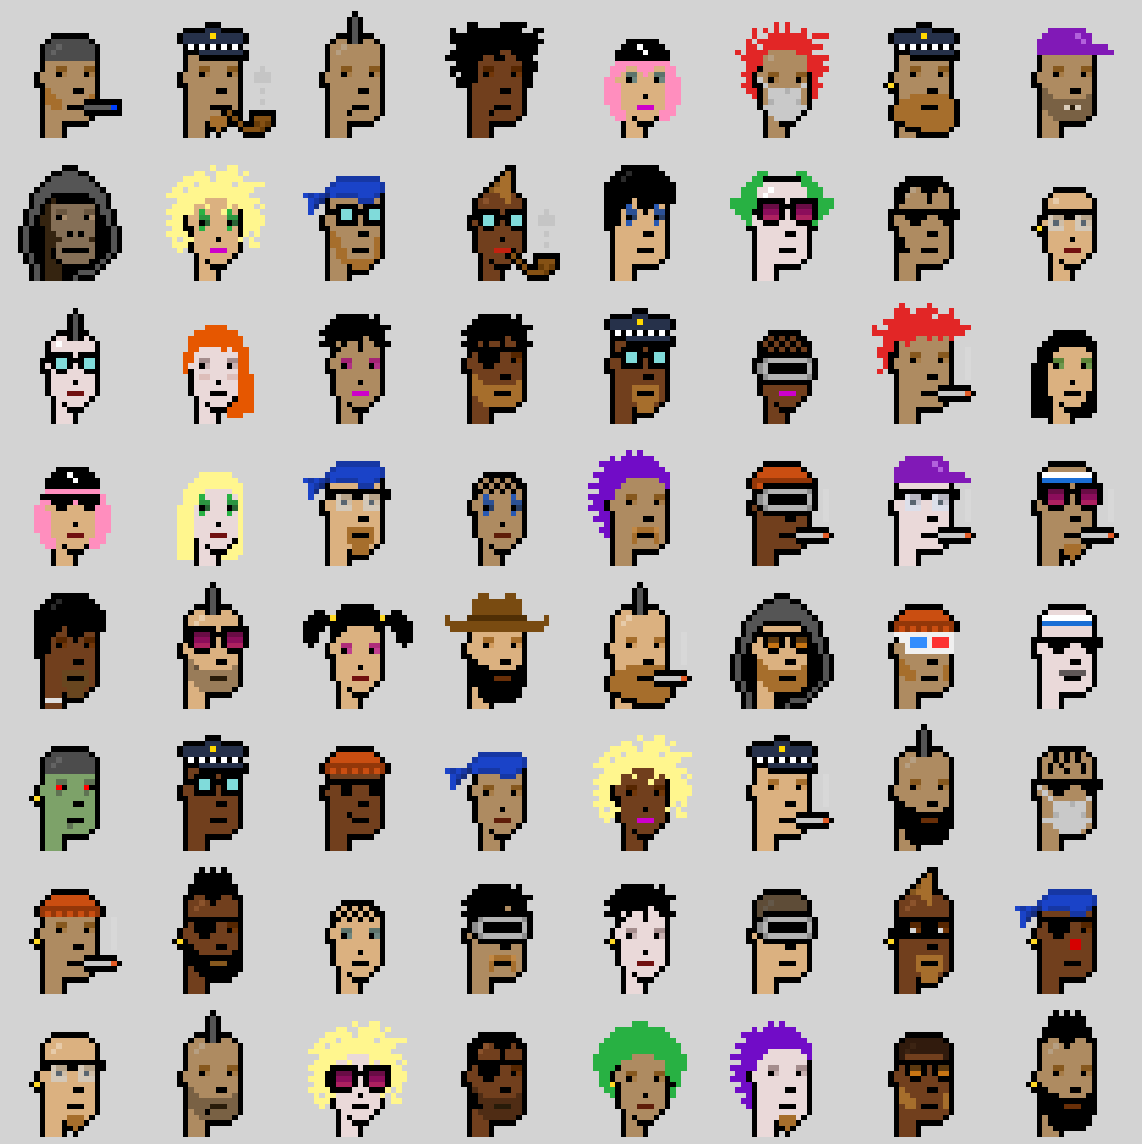

In [23]:
#2a
# Example of plotting 8 times 8 images stored in "faces" and saving the output to a file named "punks.png"
plotimgs(faces, 8, filename="punks.png")

(24, 24)


Text(0.5, 1.0, 'Plot of average opacity color weight')

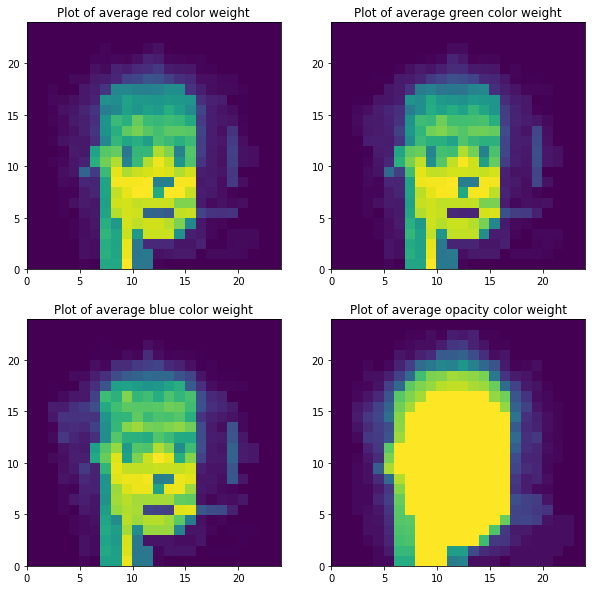

In [24]:
#2b

colorChannelMeans = np.mean(faces,axis=-1)
print(colorChannelMeans[:,:,0].shape)

fig, axs = plt.subplots(2, 2, figsize = (10, 10))
axs[0][0].pcolormesh(np.fliplr(np.flip(colorChannelMeans[:,:,0])))
axs[0][1].pcolormesh(np.fliplr(np.flip(colorChannelMeans[:,:,1])))
axs[1][0].pcolormesh(np.fliplr(np.flip(colorChannelMeans[:,:,2])))
axs[1][1].pcolormesh(np.fliplr(np.flip(colorChannelMeans[:,:,3])))
axs[0][0].set_title(f'Plot of average red color weight')
axs[0][1].set_title(f'Plot of average green color weight')
axs[1][0].set_title(f'Plot of average blue color weight')
axs[1][1].set_title(f'Plot of average opacity color weight')




The plot above show the average RGB and opacity values for the pixels taken across all pictures. A plot like this, or more specifically the values that this plot reprecent can provide valuable information about where in the datastructure the complexities lie, and thereby help us in the process of simplifying it. The compleatly purple squares in the plot show us that there are pixels that allways have $[0,0,0,0]$ as their color chanel vector. The one on the far right representing the average opacity, and as we see, there are many instances of pixels having the value 0 across all immages. Essentialy we can say that the Rank of the matrices are equal to the number of rows minus the number of rows that contain all zeros. 

In [25]:
#2c

faces_rgb = faces[:,:,:3,:]
shape = faces_rgb.shape
faces_reshaped = faces_rgb.reshape(np.prod(shape)//N, N)


d = 64

x = NMF(faces_reshaped, d, div_const, tol)
W = x[0]
H = x[1]


d = 192

x_2 = NMF(faces_reshaped, d, div_const, tol)
W_2 = x_2[0]
H_2 = x_2[1]

In [26]:


W_reshaped = W.reshape(4, 24, 3, 64)
W2_reshaped = W_2.reshape(24, 24, 3,192)



ValueError: cannot reshape array of size 110592 into shape (4,24,3,64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

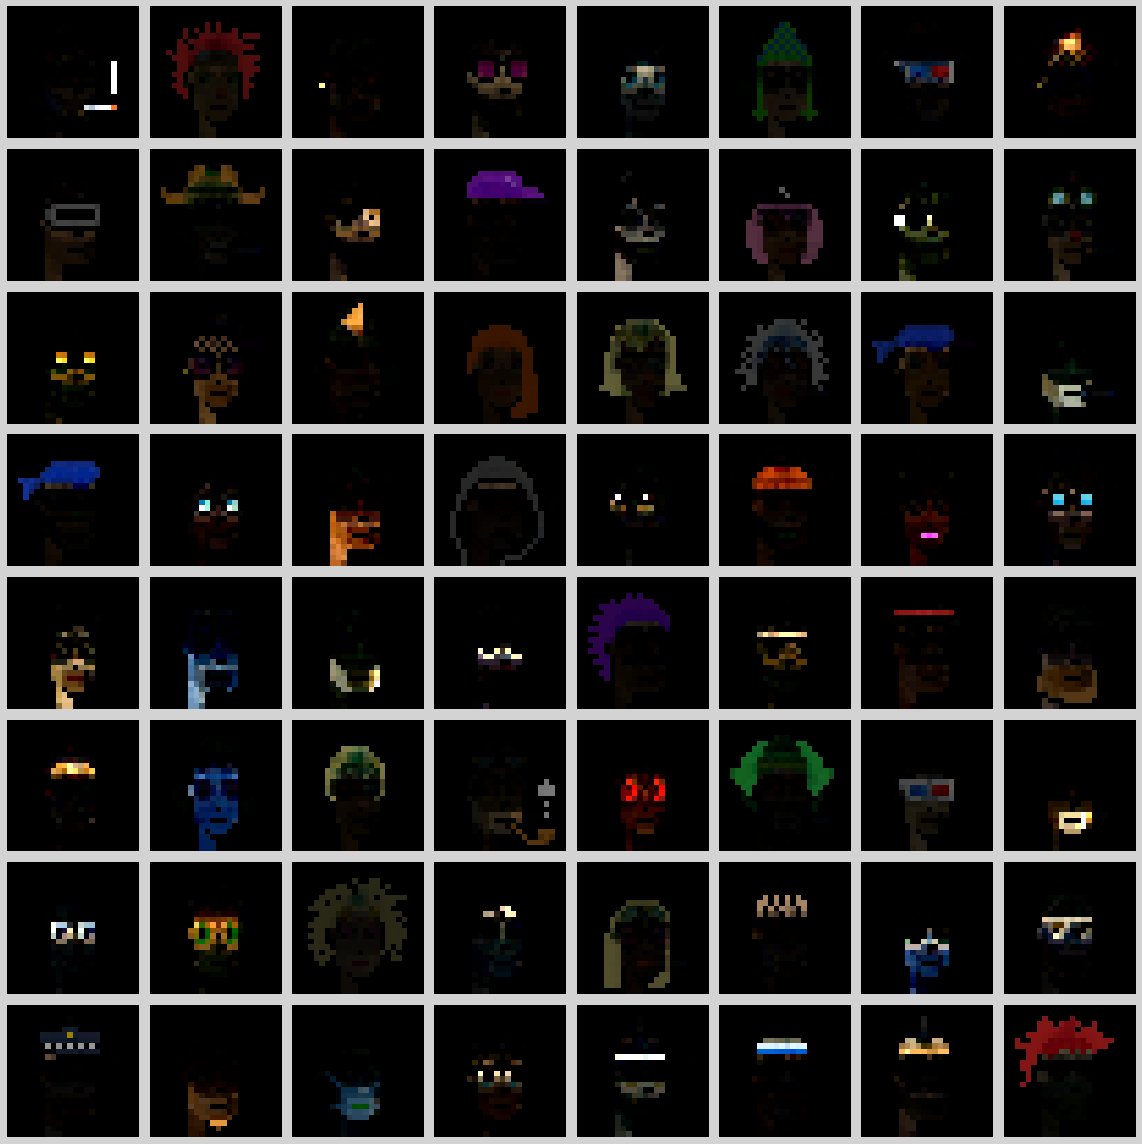

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

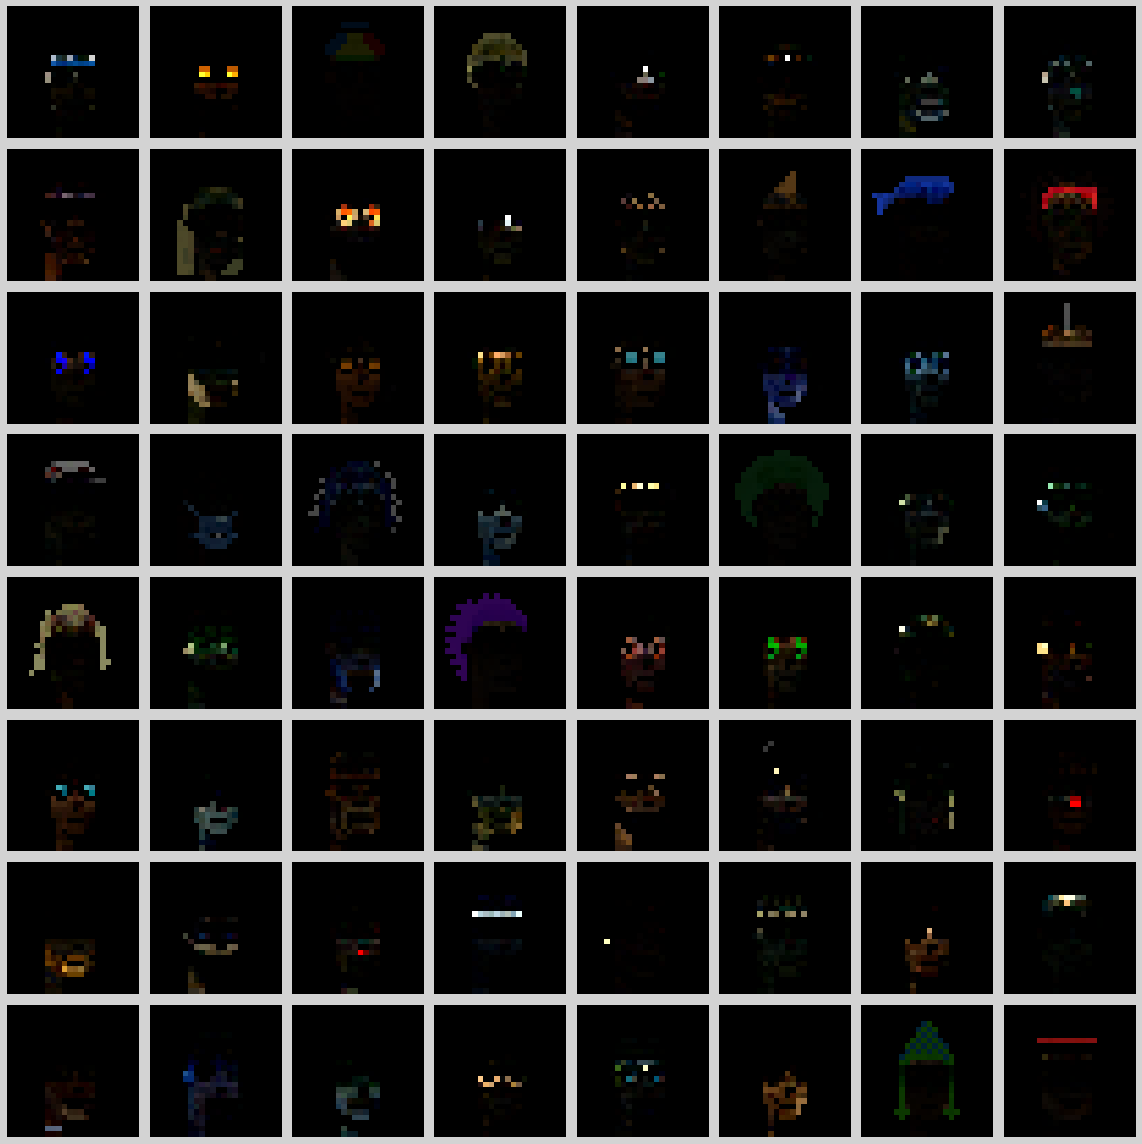

In [ ]:
#fig, axs = plt.subplots(2, 2, figsize = (10, 10))
#axs[0][0].pcolormesh(W_reshaped[:,:,0])
#axs[0][1].pcolormesh(W_reshaped[:,:,1])
#axs[1][0].pcolormesh(W_reshaped[:,:,2])
plotimgs(W_reshaped, 8, filename="W_Matrix_Columns.png")
plotimgs(W2_reshaped, 8, filename="W_Matrix_Columns_2.png")




#2c

Essensialy what se see here is a compacted representation of common structures in the original "faces" datastructure. From the resulting plot, it looks like the W-matrix captures the different accesseries that the figures wear. We can see som images of hats, glasses and hairstyles. 

In the second plot the value of d is increased threefold. It lookes like the features are less detaled, but the really common pixels are more highlighted. 

(1728, 500)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)

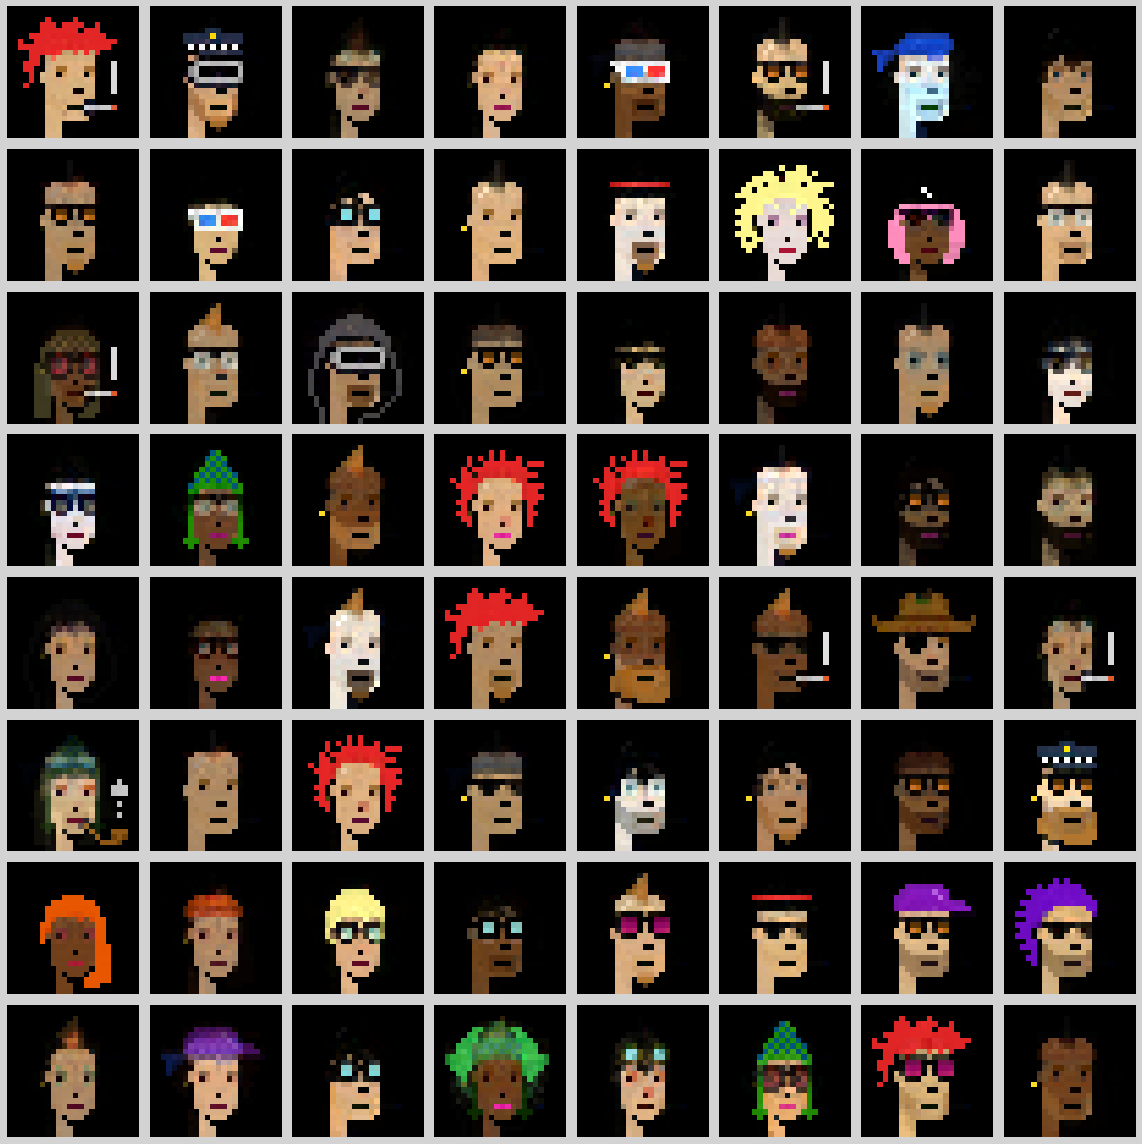

In [ ]:
#2d

faces_reconstructed = x[2]
print(faces_reconstructed.shape)

faces_reconstructed_reshaped = faces_reconstructed.reshape(24,24,3,500)

plotimgs(faces_reconstructed_reshaped, 8, filename="punks_reshaped.png")



In [ ]:
#2e) 
np.random.seed(0)

d = 16
x16 = NMF(faces_reshaped, d, div_const, tol)
norm_arr16 = x16[3]
d = 32
x32 = NMF(faces_reshaped, d, div_const, tol)
norm_arr32 = x32[3]
#x: retun fra d = 64
norm_arr64 = x[3]


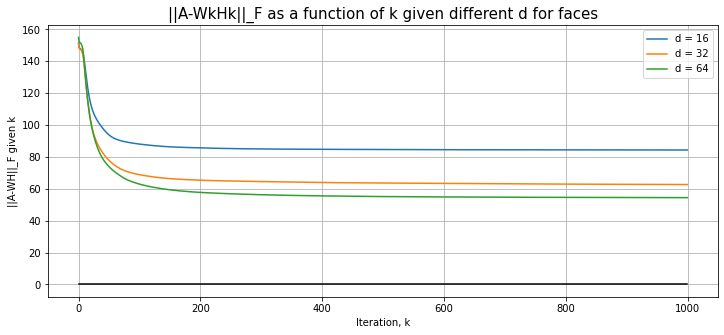

In [ ]:
#Creating an array containing the iterations: 
k = np.zeros(len(norm_arr16))
for i, value in enumerate(norm_arr16):
    k[i] = i

plt.figure(figsize=(12,5))
plt.title("||A-WkHk||_F as a function of k given different d for faces", size = 15)
plt.xlabel("Iteration, k")
plt.ylabel("||A-WH||_F given k")
plt.plot(k,np.zeros(len(k)), color="black")
plt.plot(k, norm_arr16, label = "d = 16")
plt.plot(k, norm_arr32, label = "d = 32")
plt.plot(k, norm_arr64, label = "d = 64")
plt.legend()
plt.grid()

The plots here are smiliar are reasonable in the sence that the Frobanius norm converges to a lower value given a higher $d$. As mentioned,a higher $d$ uses more data, and makes it posible to make a more exact factorization. From the looks of the plot it seems that the algorith has converged at around 600 iterations. 1000 iterations will therefor be considered enough in the next calculations. 

In [ ]:
#2f) 

#Using norm_arr16 and norm_arr64 from previous assignment
d = 128
x128 = NMF(faces_reshaped, d, div_const, tol)
norm_arr128 = x128[3]
d = 256
x256 = NMF(faces_reshaped, d, div_const, tol)
norm_arr256 = x256[3]

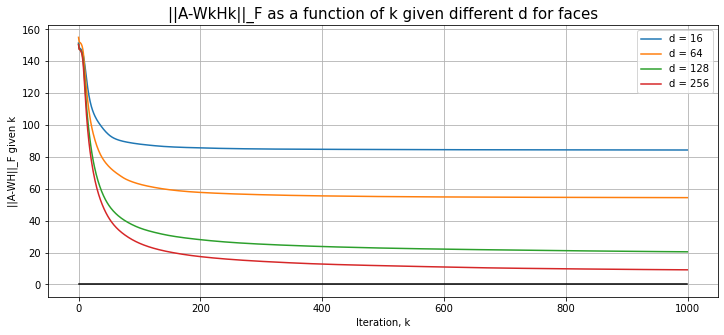

In [ ]:
plt.figure(figsize=(12,5))
plt.title("||A-WkHk||_F as a function of k given different d for faces", size = 15)
plt.xlabel("Iteration, k")
plt.ylabel("||A-WH||_F given k")
plt.plot(k,np.zeros(len(k)), color="black")
plt.plot(k, norm_arr16, label = "d = 16")
plt.plot(k, norm_arr64, label = "d = 64")
plt.plot(k, norm_arr128, label = "d = 128")
plt.plot(k, norm_arr256, label = "d = 256")
plt.legend()
plt.grid()

In [ ]:
#3a

def add_noise(imgs_reshaped, sigma = 0.1):
    """
    Adds gaussian noise to images as described in text.
    Note that imgs must be given as a (24*24*3, N) numpy array, i.e the reshaped images
    Input:
        imgs_reshaped: (1728,N) numpy array
        sigma: scalar, noise level
    Output:
        noisy_faces: (1728,N) numpy array containing noisy images
    """
    # Noise level
    sigma = 0.1

    # Array that will store the rgb channels of the noisy images
    noisy_faces = np.copy(imgs_reshaped)

    # Number of noisy values we need
    nnzero = faces_reshaped[np.nonzero(imgs_reshaped)].shape[0]

    # Sample noisy values and add noise
    noise = np.random.normal(0.0,1,nnzero)
    noisy_faces[np.nonzero(imgs_reshaped)] += sigma*noise

    # Clip to lie between 0 and 1 so that we can still interpret them as images
    noisy_faces = np.maximum(0.0,np.minimum(1.0, noisy_faces))

    return noisy_faces


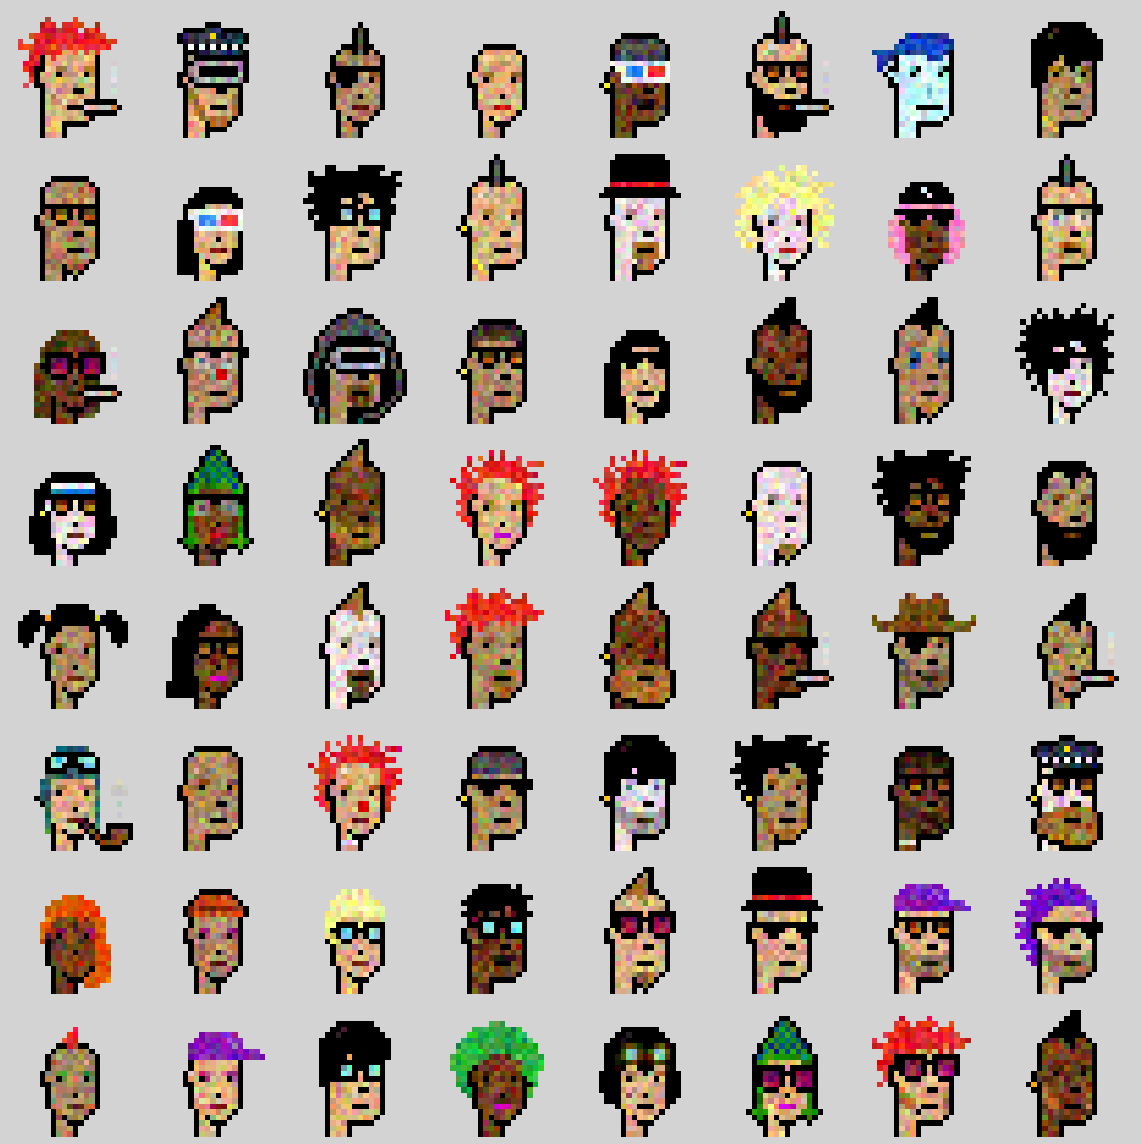

In [ ]:
#3a
faces_opacity = faces[:,:,3,:]

noisy_faces = add_noise(faces_reshaped)



# For plotting noisy images we add the opacity
noisy_faces_with_opacity = np.zeros(faces.shape)
noisy_faces_with_opacity[:,:,:3,:] = noisy_faces.reshape(faces_rgb.shape)
noisy_faces_with_opacity[:,:,3,:] = faces_opacity

plotimgs(noisy_faces_with_opacity, filename="noisy_punks.png")

In [ ]:
#3a Calculating the differance between A and A_noice in the F-norm taken from the supplied code

# Calculate the error of the noisy images
noise_residual = np.linalg.norm(noisy_faces - faces_reshaped, 'fro')
print(noise_residual)

42.34543982466479


In [ ]:
#3b
d = 64
x = NMF(noisy_faces, d, div_const, tol)



(24, 24, 3, 500)
(24, 24, 4, 500)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

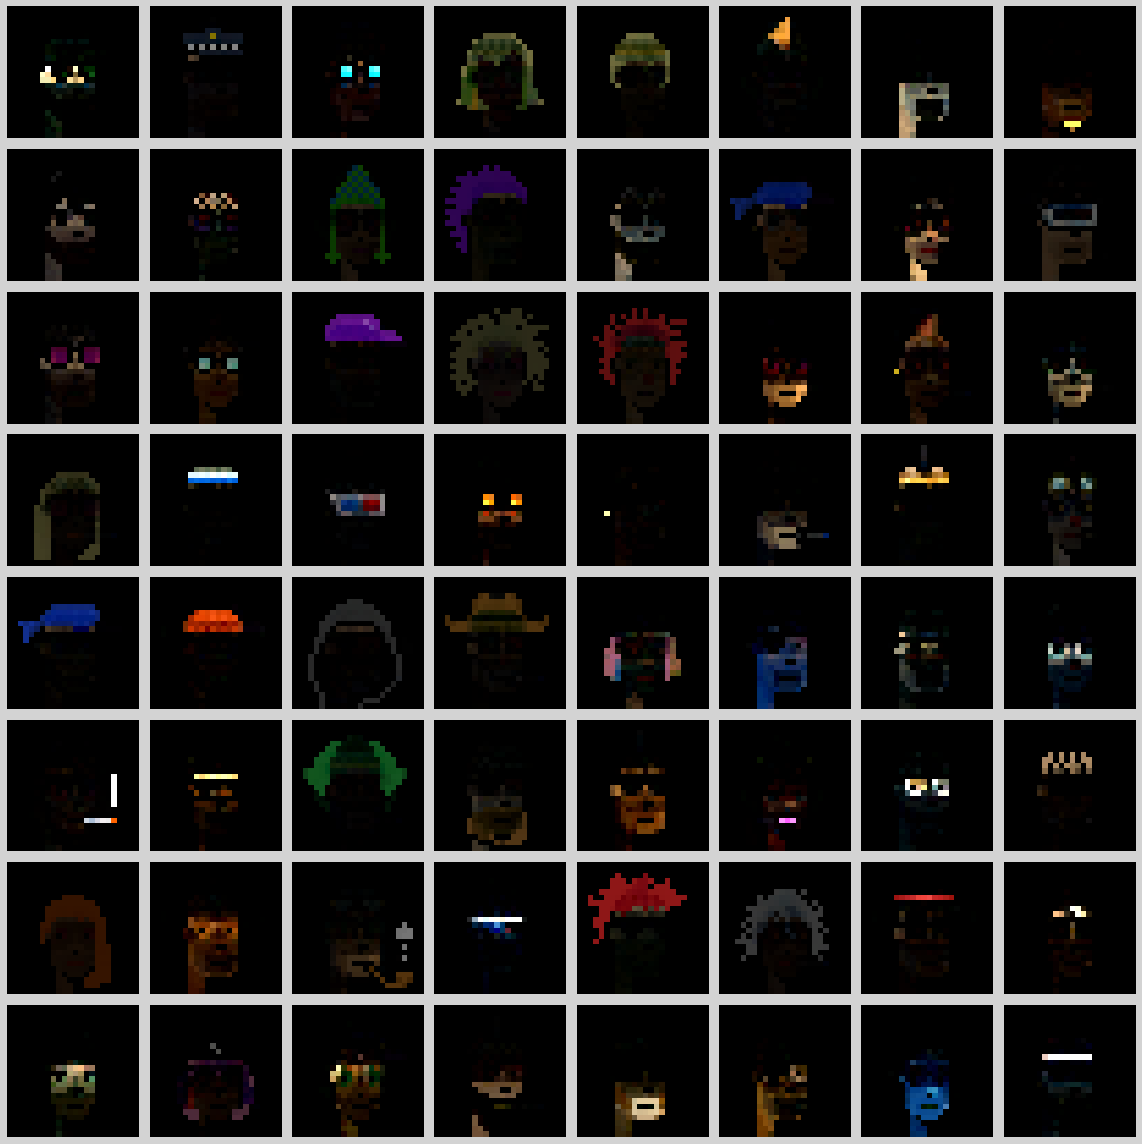

KernelInterrupted: Execution interrupted by the Jupyter kernel.

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
d = 64
#noisy_faces_W = x[0].reshape(24,24,3,d)
yy = x[2].shape
print(yy)
print(faces_rgb.reshape(1728,500).shape)
plotimgs(noisy_faces_W, 8, filename="punks_noice_W.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

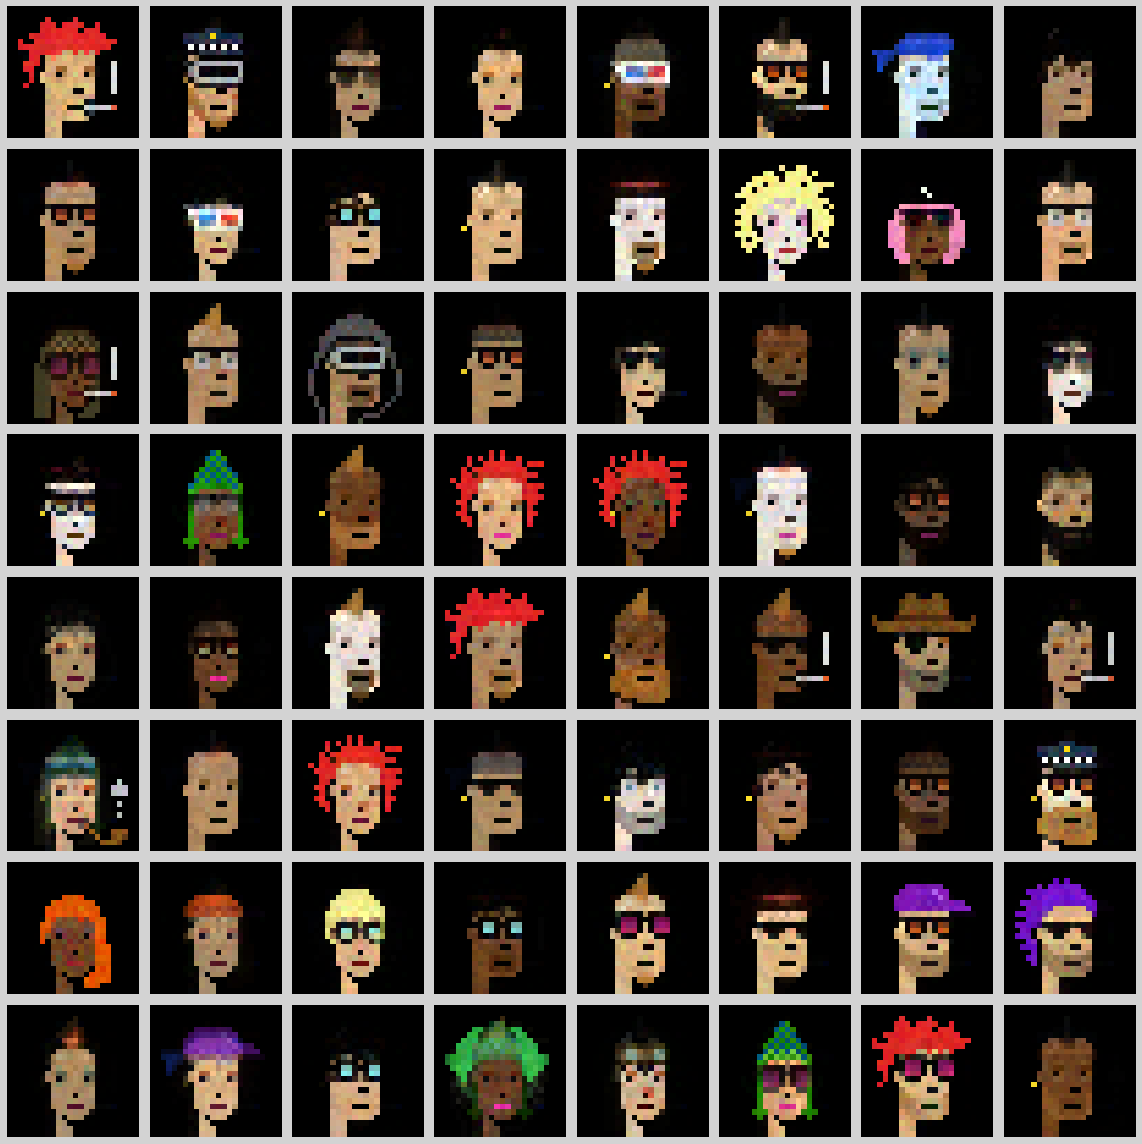

In [ ]:
d = 64
noisy_faces_reconstruction_reshaped = x[2].reshape(24,24,3,500)

plotimgs(noisy_faces_reconstruction_reshaped, 8, filename="noisy_punks_reshaped.png")




In [ ]:
#3c) 
#Calculating ||A-WH||_F as a function of d

d_range = np.around(np.linspace(16,1000, 3))
norm_arr = np.zeros(len(d_range))

print(d_range)

for i,d in enumerate(d_range): 
    x = NMF(noisy_faces, int(d), div_const, tol)
    norm = np.linalg.norm(faces_rgb-x[2], 'fro')
    norm_arr[i] = norm
    


[  16.  508. 1000.]


ValueError: operands could not be broadcast together with shapes (24,24,3,500) (1728,500) 

No handles with labels found to put in legend.


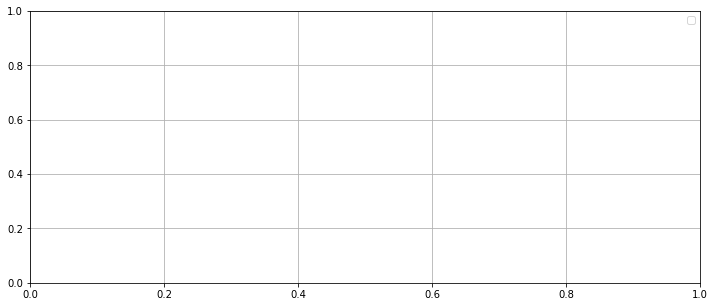

In [3]:

plt.figure(figsize=(12,5))

plt.legend()
plt.grid()
    

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7a25c552-0f8e-468e-921c-7baa56fade21' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>